In [1]:
# import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pickle

from IPython.display import Image, display
from sqlalchemy import create_engine, text
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay


In [2]:
# load extension
%load_ext sql

%load_ext autoreload

# Data Preparation

## Connect

In [3]:
# create engine
engine = create_engine(
    "sqlite:///crops_damage_report.db"
)


In [4]:
# test connection
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT sqlite_version();"))
        print("✅ Connected:", result.scalar())
        conn.close()
except Exception as e:
    print("❌ Connection failed:", e)


✅ Connected: 3.50.4


In [5]:
# connect
%sql engine

## Explore Schema

In [6]:
%%sql
    
SELECT *
FROM sqlite_schema

Running query in 'sqlite:///OneDrive/Documents/Database/crops_damage_report.db'

type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,damage_reports,damage_reports,5,"CREATE TABLE damage_reports ( report_id INTEGER PRIMARY KEY AUTOINCREMENT, plant_id INTEGER NOT NULL, damage_type TEXT, severity INTEGER, report_date DATE, FOREIGN KEY (plant_id) REFERENCES crop_plants(plant_id) )"
table,inspectors,inspectors,6,"CREATE TABLE inspectors ( inspector_id INTEGER PRIMARY KEY AUTOINCREMENT, name TEXT, region TEXT, contact TEXT )"
table,inspections,inspections,7,"CREATE TABLE inspections ( inspection_id INTEGER PRIMARY KEY AUTOINCREMENT, report_id INTEGER NOT NULL, inspector_id INTEGER NOT NULL, notes TEXT, inspection_date DATE, FOREIGN KEY (report_id) REFERENCES damage_reports(report_id), FOREIGN KEY (inspector_id) REFERENCES inspectors(inspector_id) )"
table,crops,crops,2,"CREATE TABLE crops (crop_id INTEGER PRIMARY KEY AUTOINCREMENT,crop_name TEXT NOT NULL,category TEXT)"
table,crop_plants,crop_plants,4,"CREATE TABLE crop_plants (plant_id INTEGER PRIMARY KEY AUTOINCREMENT,crop_id INTEGER NOT NULL,region TEXT,plant_date DATETIME,FOREIGN KEY (crop_id) REFERENCES crops(crop_id))"


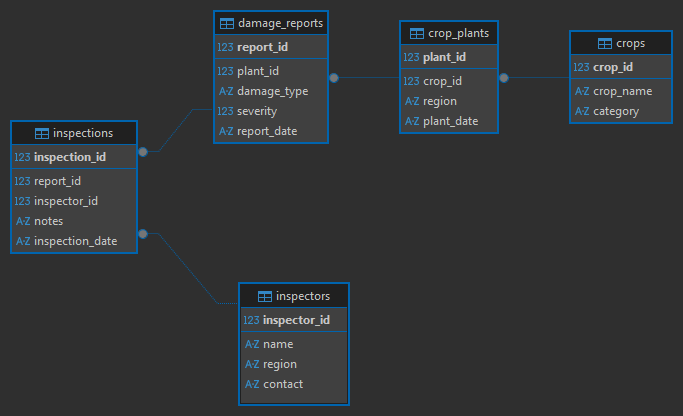

In [7]:
display(Image("/Users/Owuraku/Pictures/crops_damage.png"))

In [8]:
%%sql
PRAGMA table_info(damage_reports)

Running query in 'sqlite:///OneDrive/Documents/Database/crops_damage_report.db'

cid,name,type,notnull,dflt_value,pk
0,report_id,INTEGER,0,None,1
1,plant_id,INTEGER,1,None,0
2,damage_type,TEXT,0,None,0
3,severity,INTEGER,0,None,0
4,report_date,DATE,0,None,0


In [9]:
%%sql

SELECT count(*) as total
FROM crop_plants

Running query in 'sqlite:///OneDrive/Documents/Database/crops_damage_report.db'

total
1000


In [10]:
%%sql

SELECT cp.plant_id, 
    c.crop_name, c.category, 
    cp.region, cp.plant_date,
    dr.report_date, dr.severity, dr.damage_type,
    i.inspection_date, i.notes 
FROM crop_plants as cp
    LEFT JOIN crops as c ON cp.crop_id = c.crop_id
    LEFT JOIN damage_reports as dr ON cp.plant_id = dr.plant_id
    JOIN inspections as i ON i.report_id = dr.report_id
WHERE dr.damage_type IS NOT NULL
LIMIT 5

Running query in 'sqlite:///OneDrive/Documents/Database/crops_damage_report.db'

plant_id,crop_name,category,region,plant_date,report_date,severity,damage_type,inspection_date,notes
878,pepper,vegetables,Middle-belt,2024-08-23,2025-04-26,4,disease,2025-02-21,Fungal Infection.
154,onion,vegetables,Middle-belt,2024-05-26,2024-11-21,2,disease,2025-01-24,Stem Borer.
241,tomato,vegetables,Middle-belt,2024-06-04,2025-02-04,2,disease,2024-12-20,Pest Infestation.
799,tomato,vegetables,Middle-belt,2024-08-30,2024-12-09,8,drought,2024-12-31,Nutrient Deficiency.
413,yam,tubber,Nothern-belt,2024-06-29,2025-03-30,1,disease,2024-11-26,Fungal Infection.


## Import

In [11]:
query = """
    SELECT cp.plant_id, 
    c.crop_name, c.category, 
    cp.region, cp.plant_date,
    dr.report_date, dr.severity, dr.damage_type,
    i.inspection_date, i.notes 
    FROM crop_plants as cp
    JOIN crops as c ON cp.crop_id = c.crop_id
    LEFT JOIN damage_reports as dr ON cp.plant_id = dr.plant_id
    LEFT JOIN inspections as i ON i.report_id = dr.report_id
"""

In [12]:
# wrangle function for EDA dataset
def wrangle(query, engine):
    # extract data from database
    with engine.connect() as conn:
        df = pd.read_sql(query, conn, parse_dates=["plant_date", "report_date", "inspection_date"])
        
    # drop col
    df = df.drop("plant_id", axis=1)
    
    # add time difference col
    df["weeks_diff"] = (df["report_date"] - df["plant_date"]) // np.timedelta64(1, "W") 

    # add status col
    df["status"] = df["severity"].notnull()
    
    return df


# EDA 

In [13]:
# import dataset from db
df = wrangle(query, engine)
print(df.shape)
print(df.info())

(1934, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934 entries, 0 to 1933
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   crop_name        1934 non-null   object        
 1   category         1934 non-null   object        
 2   region           1934 non-null   object        
 3   plant_date       1934 non-null   datetime64[ns]
 4   report_date      1519 non-null   datetime64[ns]
 5   severity         1519 non-null   float64       
 6   damage_type      1519 non-null   object        
 7   inspection_date  250 non-null    datetime64[ns]
 8   notes            250 non-null    object        
 9   weeks_diff       1519 non-null   float64       
 10  status           1934 non-null   bool          
dtypes: bool(1), datetime64[ns](3), float64(2), object(5)
memory usage: 153.1+ KB
None


In [14]:
df

,crop_name,category,region,plant_date,report_date,severity,damage_type,inspection_date,notes,weeks_diff,status
0,pepper,vegetables,Southern-belt,2024-07-01,NaT,NaN,None,NaT,None,NaN,False
1,beans,legumes,Middle-belt,2024-04-29,2024-11-09,2.0,flood,NaT,None,27.0,True
2,maize,grains,Nothern-belt,2024-07-07,2024-12-21,4.0,flood,NaT,None,23.0,True
3,yam,tubber,Southern-belt,2024-08-22,NaT,NaN,None,NaT,None,NaN,False
4,pepper,vegetables,Nothern-belt,2024-07-14,2024-10-22,1.0,flood,NaT,None,14.0,True
...,...,...,...,...,...,...,...,...,...,...,...
1929,beans,legumes,Middle-belt,2024-04-04,2025-03-30,4.0,flood,NaT,None,51.0,True
1930,beans,legumes,Middle-belt,2024-04-04,2024-11-18,1.0,others,NaT,None,32.0,True
1931,beans,legumes,Middle-belt,2024-04-04,2024-10-28,3.0,pest,NaT,None,29.0,True
1932,beans,legumes,Middle-belt,2024-08-09,NaT,NaN,None,NaT,None,NaN,False


In [15]:
df["crop_name"].unique()

array(['pepper', 'beans', 'maize', 'yam', 'rice', 'onion', 'plantain',
       'tomato', 'groundnut'], dtype=object)

In [16]:
df["crop_name"].value_counts(normalize=True)*100

crop_name
beans        38.779731
pepper       25.853154
tomato        8.945191
rice          8.221303
onion         6.411582
yam           6.308170
plantain      4.239917
maize         0.982420
groundnut     0.258532
Name: proportion, dtype: float64

In [17]:
df_cat = df.groupby("category")["crop_name"].count().rename("count").to_frame().reset_index()
df_cat

,category,count
0,fruits,82
1,grains,178
2,legumes,755
3,tubber,122
4,vegetables,797


In [18]:
df_reg = df["region"].value_counts(normalize=True)
df_reg

region
Middle-belt      0.381593
Nothern-belt     0.364012
Southern-belt    0.254395
Name: proportion, dtype: float64

In [19]:
df_pdate = df["plant_date"].value_counts().to_frame().reset_index().set_index("plant_date").resample("1d").mean()

In [160]:
df_cat = df[["category" ,"status"]].value_counts(normalize=True).to_frame().reset_index()
df_cat.head()

,category,status,proportion
0,legumes,True,0.321613
1,vegetables,True,0.314891
2,vegetables,False,0.097208
3,grains,True,0.071355
4,legumes,False,0.068769


In [22]:
df_reg = df[["region" ,"status"]].value_counts(normalize=True).to_frame().reset_index()

In [23]:
pivot = df.pivot_table(values="severity", index="region", columns="category", aggfunc="mean")
pivot

category,fruits,grains,legumes,tubber,vegetables
region,,,,,
Middle-belt,3.291667,2.717949,2.702041,2.896552,2.763713
Nothern-belt,3.517241,2.579710,3.311628,2.902439,3.009901
Southern-belt,2.272727,2.733333,2.969136,4.750000,2.800000


In [161]:
df_rep_date = df["report_date"].value_counts().to_frame().reset_index().set_index("report_date").resample("1W").max().dropna()
df_rep_date.head()

,count
report_date,
2024-10-06,30
2024-10-13,35
2024-10-20,31
2024-10-27,29
2024-11-03,31


In [25]:
df_rep_date_mean = df["report_date"].value_counts().rename("mean").to_frame().reset_index().set_index("report_date").resample("1W").mean()

In [26]:
df_time = pd.concat([df_rep_date, df_rep_date_mean], axis=1, ignore_index=False)

## Visualise

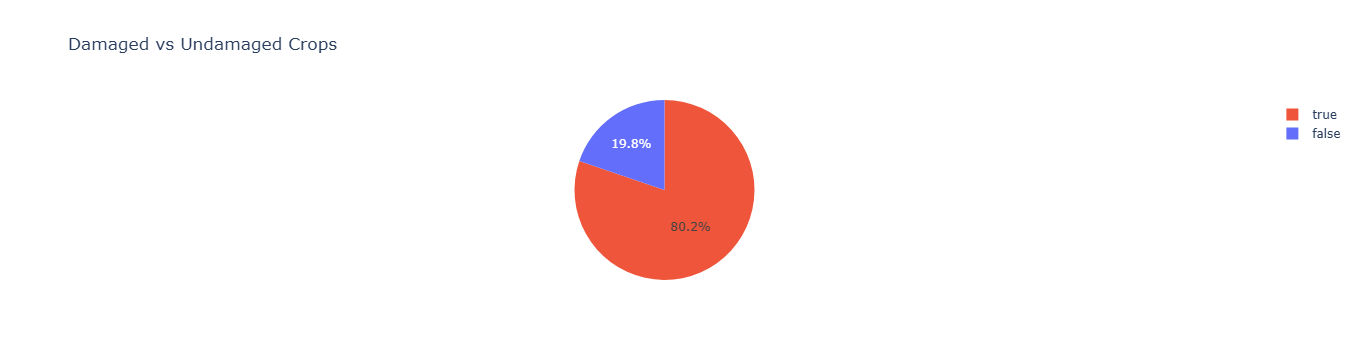

In [27]:
fig = px.pie(df, "status", df.index, color="status",title="Damaged vs Undamaged Crops")
fig.show()

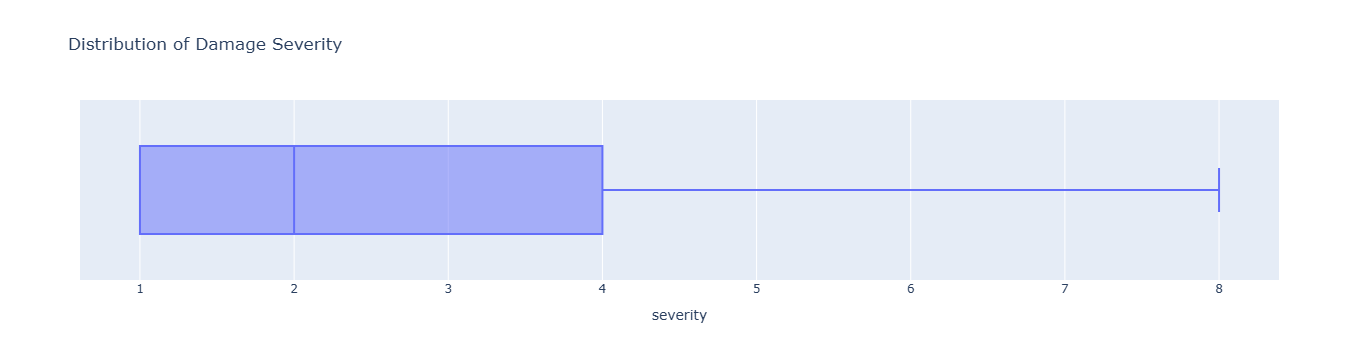

In [28]:
fig = px.box(df, "severity", title="Distribution of Damage Severity")
fig.show()

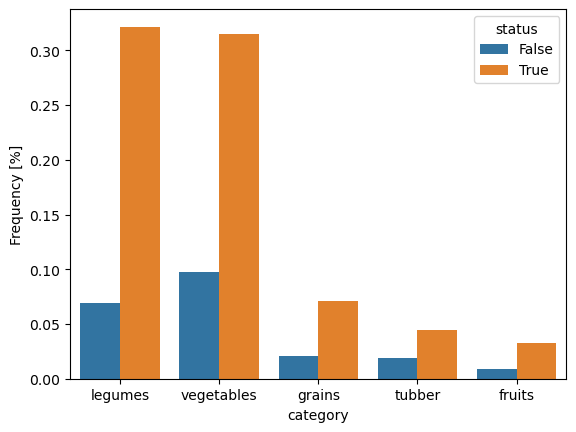

In [29]:
sns.barplot(
    df_cat, x="category", y="proportion", hue="status"
)
plt.xlabel("Crops Category")
plt.ylabel("Frequency [%]")
plt.title("Distribution of Crops Category: Damage Status);

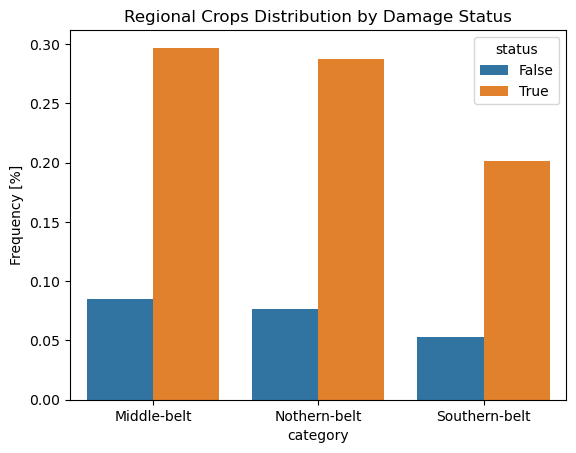

In [30]:
sns.barplot(
    df_reg, x="region", y="proportion", hue="status"
)
plt.xlabel("category")
plt.ylabel("Frequency [%]")
plt.title("Regional Crops Distribution by Damage Status");

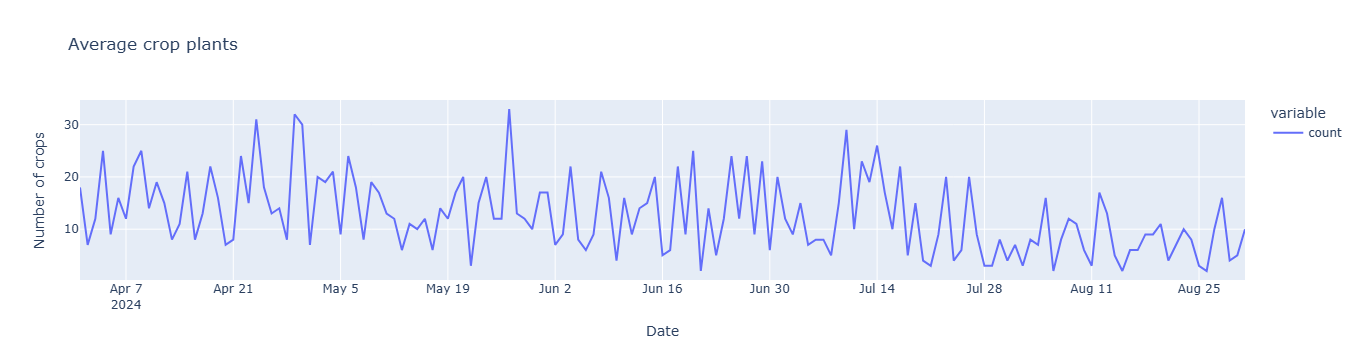

In [31]:
fig = px.line(df_pdate, title="Average crop plants")
fig.update_layout(xaxis_title="Date", yaxis_title="Number of crops")
fig.show()

<Axes: xlabel='category', ylabel='region'>

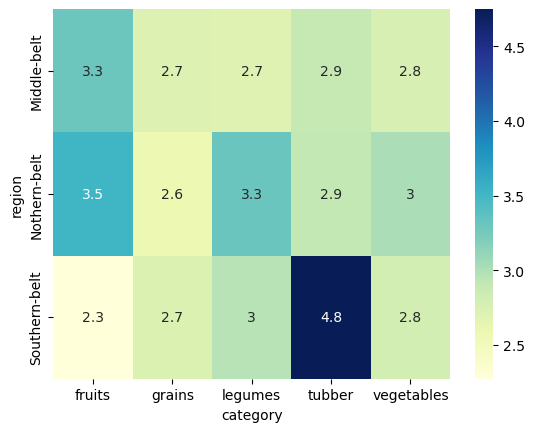

In [32]:
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Heat visuals of Region againt Crop category by Severity Intensity");

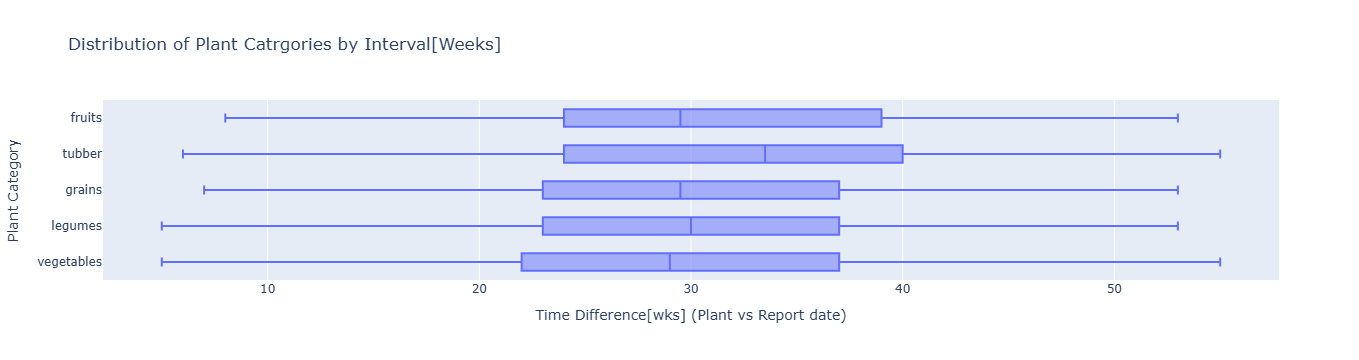

In [162]:
fig = px.box(df, "weeks_diff", "category", title="Distribution of Plant Catrgories by Interval[Weeks]")
fig.update_layout(xaxis_title="Time Difference[wks] (Plant vs Report date)", yaxis_title="Plant Category")
fig.show()

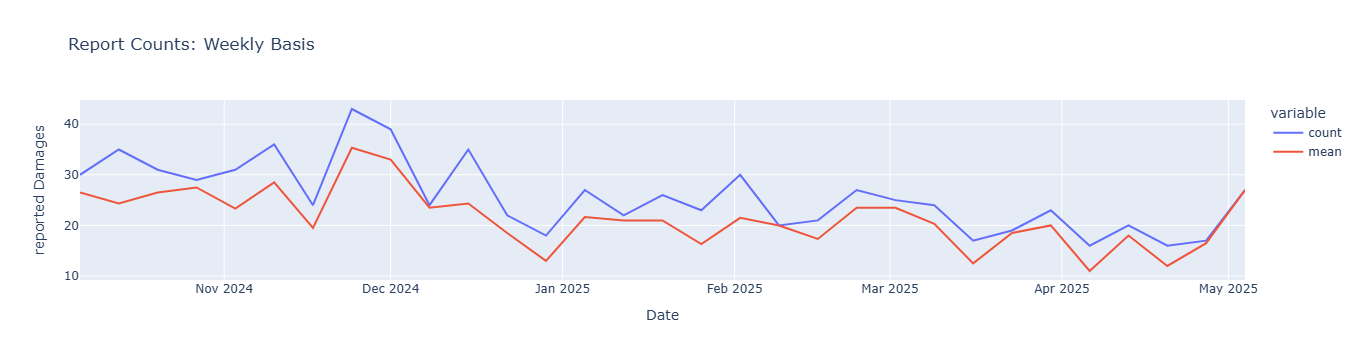

In [34]:
fig = px.line(df_time, title="Report Counts: Weekly Basis")
fig.update_layout(xaxis_title="Date", yaxis_title="reported Damages")

## Feature Engineering

In [35]:
def wrangle_moodel_data(engine, query=None):
    query = """
        SELECT cp.plant_id, 
            c.crop_name, c.category, 
            cp.region, cp.plant_date,
            dr.report_date, dr.severity, dr.damage_type,
            i.inspection_date, i.notes 
        FROM crop_plants as cp
            JOIN crops as c ON cp.crop_id = c.crop_id
            LEFT JOIN damage_reports as dr ON cp.plant_id = dr.plant_id
            LEFT JOIN inspections as i ON i.report_id = dr.report_id
        WHERE dr.damage_type IS NOT NULL
    """
    with engine.connect() as conn:
       df = pd.read_sql(query, conn, parse_dates=["plant_date", "report_date", "inspection_date"])

    # add status column
    df["status"] = df["severity"].apply(lambda x: str(x).replace(str(x), "severe") if x <= 3 else str(x).replace(str(x), "non severe"))
    mapping = {"severe": 1, "non severe": 0}
    df["class"] = df["status"].map(mapping)

    # resample planting date to months
    t_mapping = {
        4: "April",
        5: "May",
        6: "June",
        7: "July",
        8: "August"
    }

    df["plant_date_month"] = df["plant_date"].dt.month.map(t_mapping)

    # add plant / report interval
    df["weeks_difference"] = (df["report_date"] - df["plant_date"]) // np.timedelta64(1, "W")

    # remove leaky
    drop_col = ["severity", "plant_date", "report_date", "inspection_date"]

    # add high cardinality categorical features to crop list
    drop_col.append("plant_id")
    drop_col.append("notes")
    
    
    df = df.drop(drop_col, axis=1)
    
    return df

In [36]:
df_model_data = wrangle_moodel_data(engine)
print(df_model_data.shape)
print(df_model_data.info())

(1519, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   crop_name         1519 non-null   object
 1   category          1519 non-null   object
 2   region            1519 non-null   object
 3   damage_type       1519 non-null   object
 4   status            1519 non-null   object
 5   class             1519 non-null   int64 
 6   plant_date_month  1519 non-null   object
 7   weeks_difference  1519 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 95.1+ KB
None


In [37]:
df_model_data["status"].value_counts(normalize=True) * 100

status
severe        61.290323
non severe    38.709677
Name: proportion, dtype: float64

In [179]:
majority_class = "severe"
minority_class = "non severe"

In [39]:
# vertical split
target = "class"
features = df_rep_date_mean.columns
y = df_model_data[target]

In [40]:
X = df_model_data.drop([target, "status"], axis=1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("trainig shape", X_train.shape)
print("test shape", y_test.shape)

trainig shape (1215, 6)
test shape (304,)


In [178]:
# save test data
with open("X-test.csv", "x") as f:
    f.write(X_test.to_csv(index=False))
    

# Build Model

## Baseline

In [83]:
# baseline accuracy
baseline_acc = y_train.value_counts(normalize=True).max().round(2)
baseline_acc

np.float64(0.62)

In [95]:
# extract col names by datatype
num_col = X.select_dtypes("number").columns.tolist()
cat_col = X.select_dtypes("object").columns.tolist()

## Iterate

In [96]:
# create predictor 
rf = make_pipeline(
    ColumnTransformer(
        [
            ("cat", OrdinalEncoder(), cat_col),
            ("num", StandardScaler(), num_col)
        ]
    ),
    RandomForestClassifier(random_state=42)
)

In [97]:
# spcify hyperparameters 
arams = {
    "randomforestclassifier__n_estimators": range(100, 301, 100),
    "randomforestclassifier__max_depth": [None, 10, 20],
    "randomforestclassifier__min_samples_split": [2, 5, 10]
}

In [98]:
# fit gridsearch
temp_model = GridSearchCV(
    rf,
    params,
    scoring="accuracy",
    n_jobs=-1,
    cv=5,
    verbose=1
)
temp_model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'randomforestclassifier__max_depth': [None, 10, ...], 'randomforestclassifier__min_samples_split': [2, 5, ...], 'randomforestclassifier__n_estimators': range(100, 301, 100)}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more message

In [99]:
# extract results
cv_results = pd.DataFrame(temp_model.cv_results_)

In [100]:
cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   mean_fit_time                                    27 non-null     float64
 1   std_fit_time                                     27 non-null     float64
 2   mean_score_time                                  27 non-null     float64
 3   std_score_time                                   27 non-null     float64
 4   param_randomforestclassifier__max_depth          18 non-null     object 
 5   param_randomforestclassifier__min_samples_split  27 non-null     int64  
 6   param_randomforestclassifier__n_estimators       27 non-null     int64  
 7   params                                           27 non-null     object 
 8   split0_test_score                                27 non-null     float64
 9   split1_test_score                 

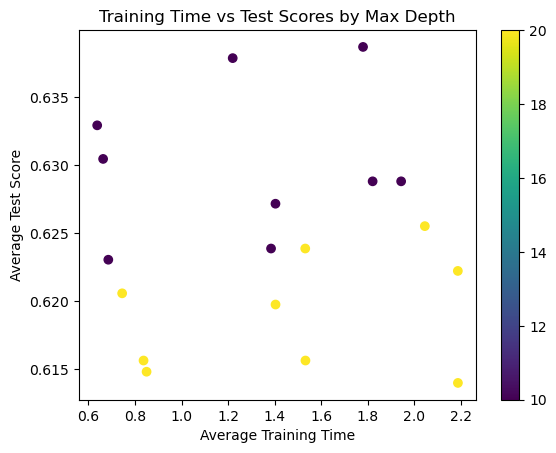

In [181]:
plt.scatter(cv_results["mean_fit_time"], cv_results["mean_test_score"], c=cv_results["param_randomforestclassifier__max_depth"])
plt.xlabel("Average Training Time")
plt.ylabel("Average Test Score")
plt.title("Training Time vs Test Scores by Max Depth")
plt.colorbar();

In [127]:
cv_results_pivot = cv_results.pivot_table(
    values="mean_test_score", index="param_randomforestclassifier__min_samples_split", columns="param_randomforestclassifier__n_estimators", aggfunc="max"
)

In [128]:
cv_results_pivot.style.background_gradient(axis=None)

param_randomforestclassifier__n_estimators,100,200,300
param_randomforestclassifier__min_samples_split,,,
2,0.632922,0.637860,0.638683
5,0.630453,0.627160,0.628807
10,0.623045,0.623868,0.628807


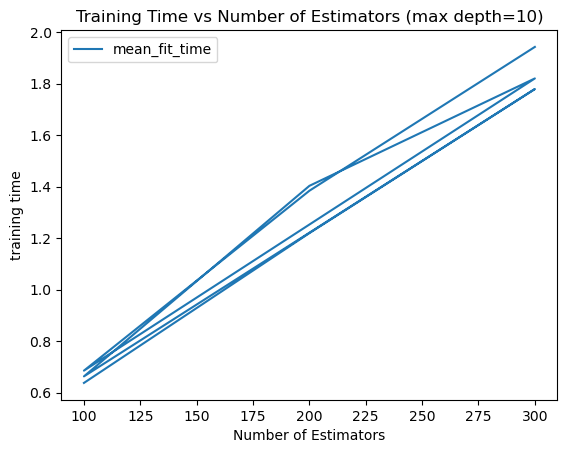

In [185]:
cv_results[cv_results["param_randomforestclassifier__max_depth"] == 10].plot("param_randomforestclassifier__n_estimators","mean_fit_time")
plt.xlabel("Number of Estimators")
plt.ylabel("training time")
plt.title("Training Time vs Number of Estimators (max depth=10)");

In [110]:
temp_model.best_score_

np.float64(0.6386831275720164)

In [124]:
# get best parameters
temp_model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 300}

In [133]:
model = temp_model.best_estimator_

## Evaluate

In [143]:
y_pred = model.predict(X_test)

In [145]:
print("test score", accuracy_score(y_test, y_pred))

test score 0.569078947368421


# Communicate

In [136]:
importance = model.named_steps["randomforestclassifier"].feature_importances_

In [140]:
feat_imp = pd.Series(importance, X_train.columns).sort_values(ascending=False)

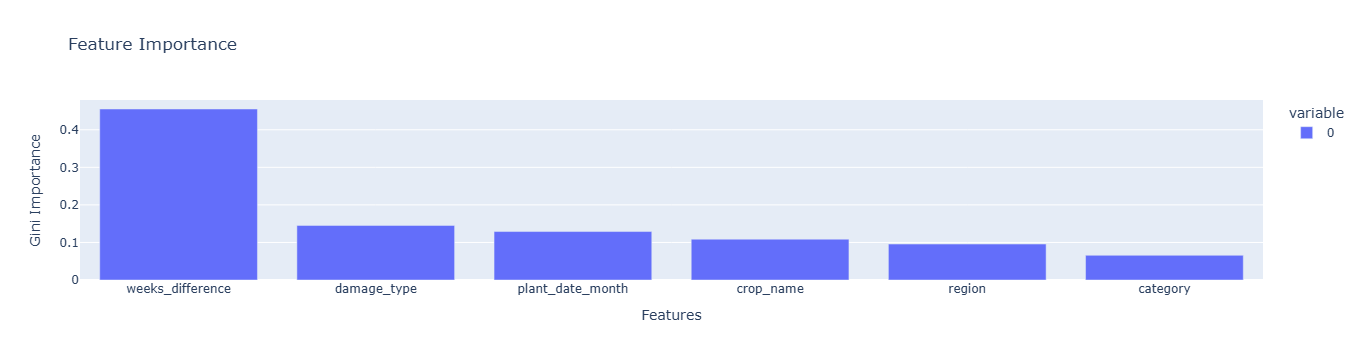

In [141]:
fig = px.bar(feat_imp, title="Feature Importance")
fig.update_layout(xaxis_title="Features", yaxis_title="Gini Importance")
fig.show()

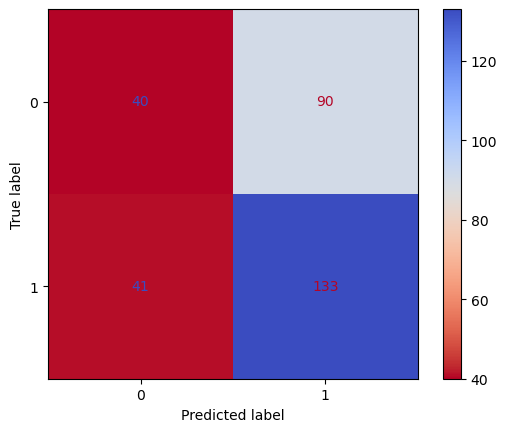

In [156]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="coolwarm_r");

In [ ]:
# save model
with open("model-clf-crop-dmg.pkl", "xb") as f:
    pickle.dump(model, f)